First Order Indices: [0.75244,-0.00649072,-0.00644791,0.107387,-0.00615246,0.0825138,0.0931634,0.0252584]
Total Order Indices: [0.701461,0.000142471,-4.95547e-08,0.114037,-1.70594e-05,0.114838,0.0803544,0.033191]
2nd order index (1,0)=-0.0159042
2nd order index (2,0)=-0.0158903
2nd order index (2,1)=-0.0531363
2nd order index (3,0)=0.023455
2nd order index (3,1)=-0.0531562
2nd order index (3,2)=-0.053073
2nd order index (4,0)=-0.0157375
2nd order index (4,1)=-0.0531364
2nd order index (4,2)=-0.0530729
2nd order index (4,3)=-0.0441319
2nd order index (5,0)=-0.00799132
2nd order index (5,1)=-0.053141
2nd order index (5,2)=-0.0530729
2nd order index (5,3)=-0.049969
2nd order index (5,4)=-0.0532612
2nd order index (6,0)=-0.0224197
2nd order index (6,1)=-0.0531204
2nd order index (6,2)=-0.0530729
2nd order index (6,3)=-0.0449756
2nd order index (6,4)=-0.0532891
2nd order index (6,5)=-0.0500484
2nd order index (7,0)=-0.00630945
2nd order index (7,1)=-0.0531054
2nd order index (7,2)=-0.053073

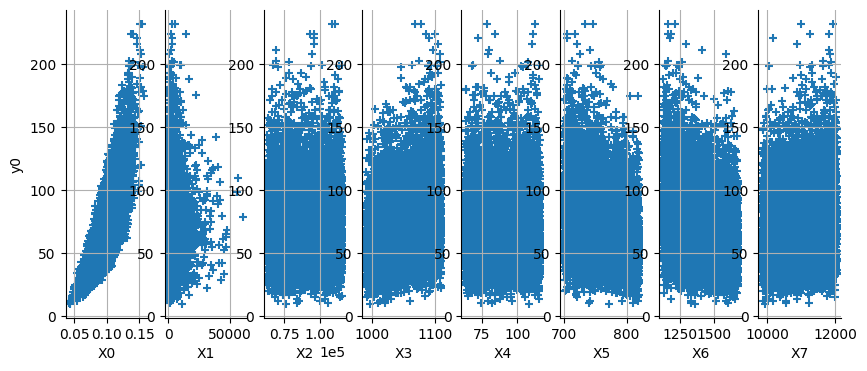

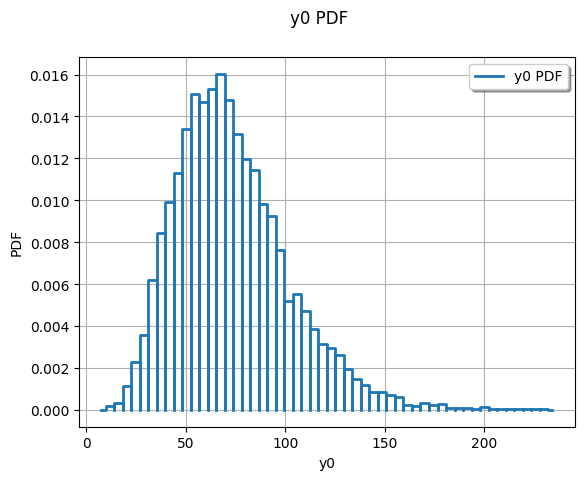

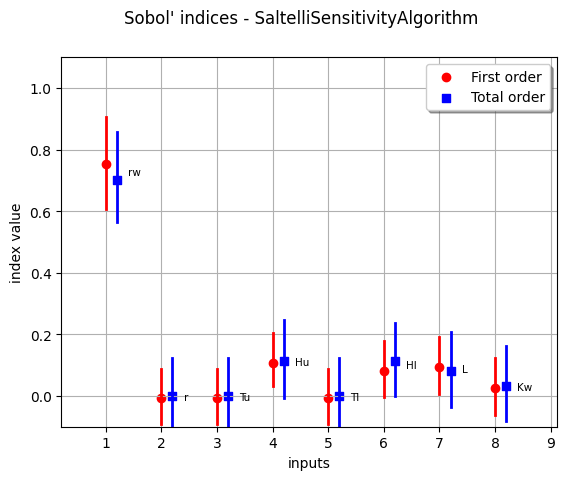

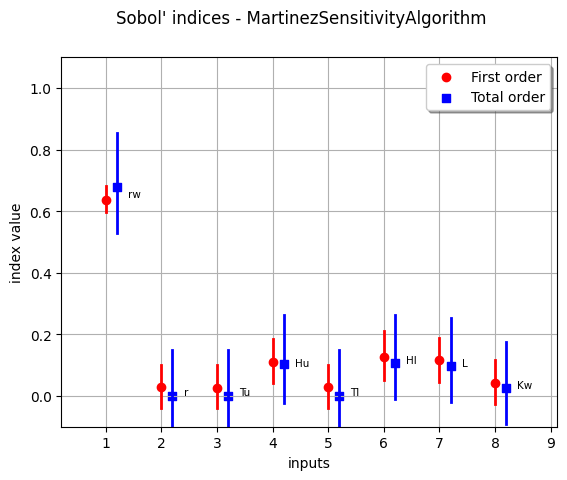

In [1]:
"""
Estimate Sobol' indices for the Flood model by a sampling method
================================================================
"""

import openturns as ot
import importlib.util
import sys
import os
import openturns.viewer as otv
from matplotlib import pylab as plt
import pandas as pd

# Load the flood model
module_name = "FloodModel"
file_path = "examples/Water.py"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} does not exist.")

spec = importlib.util.spec_from_file_location(module_name, file_path)
if spec is None:
    raise ImportError(f"Could not load the module from {file_path}.")

module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

function_of_interest, problem = module.model, module.problem

# Create distributions
distributions = ot.DistributionCollection()
for dist_info in problem['distributions']:
    dist_type = dist_info['type']
    params = dist_info['params']
    if dist_type == 'Uniform':
        distributions.add(ot.Uniform(*params))
    elif dist_type == 'Normal':
        distributions.add(ot.Normal(*params))
    elif dist_type == 'LogNormalMuSigma':
        distributions.add(ot.ParametrizedDistribution(ot.LogNormalMuSigma(*params)))
    elif dist_type == 'LogNormal':
        distributions.add(ot.LogNormal(*params))
    elif dist_type == 'Beta':
        distributions.add(ot.Beta(*params))
    elif dist_type == 'Gumbel':
        distributions.add(ot.Gumbel(*params))
    elif dist_type == 'Triangular':
        distributions.add(ot.Triangular(*params))
    else:
        raise ValueError(f"Unsupported distribution type: {dist_type}")

distribution = ot.ComposedDistribution(distributions)

# Define the OpenTURNS model
ot_model = ot.PythonFunction(problem['num_vars'], 1, function_of_interest)

# Draw the function
n = 10000
sampleX = distribution.getSample(n)
sampleY = ot_model(sampleX)

def plotXvsY(sampleX, sampleY):
    """
    Plot a Y sample against a X sample on a grid.

    Parameters
    ----------
    sampleX : ot.Sample(sampleSize, inputDimension)
        The input sample.
    sampleY : ot.Sample(sampleSize, outputDimension)
        The output sample.

    Returns
    -------
    grid: ot.GridLayout(outputDimension, inputDimension)
        The grid of plots of all projections of Y vs X.
    """
    dimX = sampleX.getDimension()
    dimY = sampleY.getDimension()
    descriptionX = sampleX.getDescription()
    descriptionY = sampleY.getDescription()
    grid = ot.GridLayout(dimY, dimX)
    for i in range(dimY):
        for j in range(dimX):
            graph = ot.Graph("", descriptionX[j], descriptionY[i], True, "")
            cloud = ot.Cloud(sampleX[:, j], sampleY[:, i])
            graph.add(cloud)
            if j == 0:
                graph.setYTitle(descriptionY[i])
            else:
                graph.setYTitle("")
            if i == dimY - 1:
                graph.setXTitle(descriptionX[j])
            else:
                graph.setXTitle("")
            grid.setGraph(i, j, graph)
    return grid

grid = plotXvsY(sampleX, sampleY)
_ = ot.viewer.View(grid, figure_kw={"figsize": (10.0, 4.0)})

graph = ot.HistogramFactory().build(sampleY).drawPDF()
view = otv.View(graph)

# Estimate the Sobol' indices
size = 1000
sie = ot.SobolIndicesExperiment(distribution, size)
inputDesign = sie.generate()
input_names = problem['names']
inputDesign.setDescription(input_names)
inputDesign.getSize()

outputDesign = ot_model(inputDesign)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

first_order_indices = sensitivityAnalysis.getFirstOrderIndices()
total_order_indices = sensitivityAnalysis.getTotalOrderIndices()

print("First Order Indices:", first_order_indices)
print("Total Order Indices:", total_order_indices)

graph = sensitivityAnalysis.draw()
view = otv.View(graph)

# Estimate the second order indices
size = 1000
computeSecondOrder = True
sie = ot.SobolIndicesExperiment(distribution, size, computeSecondOrder)
inputDesign = sie.generate()
inputDesign.setDescription(input_names)
outputDesign = ot_model(inputDesign)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

second_order = sensitivityAnalysis.getSecondOrderIndices()
for i in range(len(problem['names'])):
    for j in range(i):
        print("2nd order index (%d,%d)=%g" % (i, j, second_order[i, j]))

# Using a different estimator
sensitivityAnalysis = ot.MartinezSensitivityAlgorithm(inputDesign, outputDesign, size)

graph = sensitivityAnalysis.draw()
view = otv.View(graph)

plt.show()
